In [31]:
import sympy

sympy.init_printing()

## Sensitivity Calculation
The sensitvity of an IACT is defined as the minimum flux needed to observe a (point) source with a significance of least $\sigma_{target}$ within a fixed amount of time $t_{ref}$.
After analysing the high-level IACT data you're left with the number of events from the source region from the sky and the number of events from the background region in the sky. Namely $N_{on}$ and  $N_{off}$. Usually, if not always, the source and background regions have different sizes. The ration between these is called $\alpha$.

In [32]:
n_on, n_off, alpha, t_obs, t_ref, relative_flux = sympy.var([
    'N_\mathrm{on}',
    'N_\mathrm{off}',
    'alpha',
    't_\mathrm{obs}',
    't_\mathrm{ref}',
    '\phi_\mathrm{rel}',
])

ratio = t_obs/t_ref

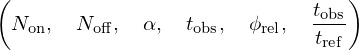

In [33]:
n_on, n_off, alpha, t_obs, relative_flux, ratio

The good old Li&Ma formula calculates the significance of an observation based on the numbers above.

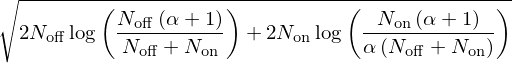

In [34]:
p_on = n_on / (n_on + n_off)
p_off = n_off / (n_on + n_off)

t1 = n_on * sympy.log(((1 + alpha) / alpha) * p_on)
t2 = n_off * sympy.log((1 + alpha) * p_off)

S_li_ma = sympy.sqrt(2 * (t1 + t2))

sympy.simplify(S_li_ma)

Scale the counts to the expected numbers taking into account the reference time (i.e. 50 hours) 
and the actual observation time (which of course only really defined for real observations)

In [35]:
scale = t_ref / t_obs * relative_flux

scaled_li_ma = sympy.simplify(S_li_ma.subs({n_on: n_on * scale, n_off: n_off * scale}))

The target significance is pre defined and fixed (usually set to 5 sigma). So we create an equality between the target sigma and the scaled Li&Ma formula and solve for the flux.

In [45]:
target_significance = sympy.Symbol('\sigma_\mathrm{target}')
eq = sympy.Equality(scaled_li_ma, target_significance)

Sensitivity = 


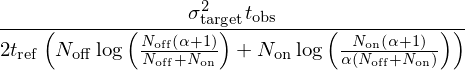

In [50]:
print('Sensitivity = ')
sympy.solve(eq, relative_flux)[0].simplify()